In [1]:
import csv
import math
import patsy 
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.graphics import utils
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()
# %matplotlib inline

/Users/Dong-hyun/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## [House Price: Adcanced Regressin Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

+ Project summary

+ Goal
	* it is your job to predict the sales price for each house.
	* For each Id in test set, you must predict the value of the SalePrice variable.

+ Metric
	* submissions are evaluated in Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.(Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally)

+ porject index
	* EDA(Exploratory data analysis)
	* Feature selection
	* Modeling(OLS Regression)
	* Model selection


# EDA 
+ 변수 탐색 및 분류
  + 변수가 무엇을 의미하는지 파악
  + 상관관계가 없는 변수는 어떤것이 있나?
  + 의미없는값, 전처리가 필요한 값들을 선별및 가공하자
  + 판매가격과 상관관계가 없는 변수는 어떻게 처리할 것인가?  #오탈자 수정



## data describe & target describe

In [2]:
# target feature인 SslePrice를 dfy 변수로 지정
# SalePrice를 제외한 traing data를 dfX 변수로 지정
# 기준 index로 잡은 Id feature의 value 재설정 (전체 데이터 중 일부를 추출한 데이터이기 때문에 연속적이지 않음)       
df = pd.read_csv('./data/train.csv')
df['Id'] = np.where(df['Id']>0, range(0,1029+1), df['Id'])
df = df.set_index("Id")

dfy = pd.DataFrame(df, columns=['SalePrice'])
dfX = df.drop('SalePrice', axis=1)


df = pd.concat([dfX, dfy], axis=1)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1025,90,RL,60.0,9000,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,Duplex,2Story,5,5,1974,1974,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,896,896,GasA,TA,Y,SBrkr,896,896,0,1792,0,0,2,2,4,2,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,32,45,0,0,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal,136000
1026,20,RL,78.0,9262,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2008,2009,Gable,CompShg,CemntBd,CmentBd,Stone,194.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1573,1573,GasA,Ex,Y,SBrkr,1578,0,0,1578,0,0,2,0,3,1,Ex,7,Typ,1,Gd,Attchd,2008.0,Fin,3,840,TA,TA,Y,0,36,0,0,0,0,NaN,NaN,NaN,0,5,2009,New,Partial,287090
1027,20,RL,90.0,17217,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1140,1140,GasA,Ex,Y,SBrkr,1140,0,0,1140,0,0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,36,56,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Abnorml,84500
1028,20,FV,62.0,7500,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,410,Unf,0,811,1221,GasA,Ex,Y,SBrkr,1221,0,0,1221,1,0,2,0,2,1,Gd,6,Typ,0,NaN,Attchd,2004.0,RFn,2,400,TA,TA,Y,0,113,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,185000
1029,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
# train data 중 실수값을 value 로 갖는 feature 들의 describe
# count 항목을 통해 LotArea / MasVnrArea feature의 missing value 존재 확인
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1030.000000,852.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1026.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.00000,1030.000000,1030.000000,1030.000000,1030.000000,973.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.00000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,55.543689,70.264085,10739.995146,6.113592,5.553398,1972.049515,1984.533010,106.712476,447.696117,46.509709,572.577670,1066.783495,1163.185437,348.624272,7.214563,1519.024272,0.411650,0.060194,1.566990,0.38835,2.865049,1.036893,6.520388,0.612621,1978.606372,1.774757,473.315534,95.205825,46.602913,20.44466,3.745631,15.158252,2.026214,28.689320,6.273786,2007.756311,181529.582524
std,41.742833,24.006403,11381.288115,1.368715,1.088219,29.625332,20.740199,182.215365,467.521505,161.217951,438.785772,447.501650,393.614453,433.443217,55.592293,523.062751,0.513624,0.245994,0.542533,0.50523,0.808267,0.203464,1.623764,0.630020,24.648731,0.742794,211.744787,124.859370,66.664052,59.19463,32.421234,57.149755,32.538417,303.621693,2.657441,1.323274,78070.440130
min,20.000000,21.000000,1491.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.000000,0.000000,0.000000,438.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,3.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7590.000000,5.000000,5.000000,1954.000000,1966.250000,0.000000,0.000000,0.000000,230.000000,804.000000,882.000000,0.000000,0.000000,1131.000000,0.000000,0.000000,1.000000,0.00000,2.000000,1.000000,5.000000,0.000000,1962.000000,1.000000,338.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129925.000000
50%,50.000000,70.000000,9512.500000,6.000000,5.000000,1974.000000,1993.000000,0.000000,384.000000,0.000000,483.500000,992.000000,1088.500000,0.000000,0.000000,1479.000000,0.000000,0.000000,2.000000,0.00000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,478.500000,0.000000,24.000000,0.00000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,165000.000000
75%,60.000000,80.000000,11638.500000,7.000000,6.000000,2001.000000,2004.000000,170.750000,704.750000,0.000000,809.500000,1294.750000,1389.750000,737.000000,0.000000,1789.500000,1.000000,0.000000,2.000000,1.00000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,170.250000,67.750000,0.00000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,215000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,1872.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.00000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.00000,508.000000,480.000000,576.000000,8300.000000,12.000000,2010.000000,755000.000000


In [4]:
# missing value 가 존재하는 feature들의 describe 확인
dfX[['LotFrontage','MasVnrArea']].describe()

,LotFrontage,MasVnrArea
count,852.000000,1026.000000
mean,70.264085,106.712476
std,24.006403,182.215365
min,21.000000,0.000000
25%,59.000000,0.000000
50%,70.000000,0.000000
75%,80.000000,170.750000
max,313.000000,1600.000000


In [5]:
# LotFrontage feature의 missing value를 중앙값을 대체
# MasVnrArea feature의 missing value를 0 값으로 대체
dfX['LotFrontage'] = dfX['LotFrontage'].fillna(dfX['LotFrontage'].median())
dfX['MasVnrArea'] = dfX['MasVnrArea'].fillna(0)
dfX[['LotFrontage','MasVnrArea']].describe()

,LotFrontage,MasVnrArea
count,1030.000000,1030.000000
mean,70.218447,106.298058
std,21.831759,181.982051
min,21.000000,0.000000
25%,60.000000,0.000000
50%,70.000000,0.000000
75%,80.000000,170.000000
max,313.000000,1600.000000


In [6]:
# 비어있는칸의 갯수 확인
# 연도나 Categorical 변수들은 특성을 더 살펴본뒤에 전처리할예점
# 대부분 상태나 등급들 나타내는 변수임
# ex) Garage가 없는집은 GarageQual이 없음
df = pd.concat([dfX, dfy], axis=1)
null_count = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
null_count.head(20)

,0
PoolQC,1026
MiscFeature,997
Alley,971
Fence,834
FireplaceQu,477
GarageQual,57
GarageCond,57
GarageFinish,57
GarageType,57
GarageYrBlt,57


In [7]:
# target feature인 SalePrice의 dscribe 확인
df['SalePrice'].describe()

count      1030.000000
mean     181529.582524
std       78070.440130
min       34900.000000
25%      129925.000000
50%      165000.000000
75%      215000.000000
max      755000.000000
Name: SalePrice, dtype: float64

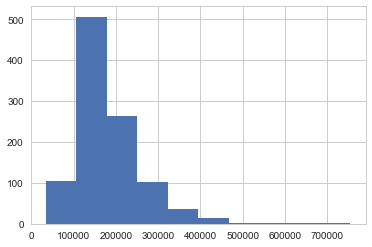

In [8]:
# target feature인 SalePrice의 분포를 히스토그램으로 확인
# 왜도가 높게 나옴
plt.hist(df.SalePrice)
plt.show()

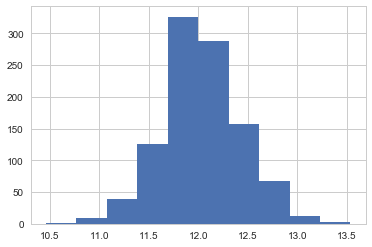

In [9]:
# 왜도를 낮춤
# 로그를 사용하는건 ols에서 사용할 예정
log_SalePrice = np.log(df['SalePrice'])
plt.hist(log_SalePrice)
plt.show()

## Numeric Feature와 Categorical Feature 분류

* numeric value를 갖는 feature와 categorical value를 갖는 feature 구분
* nemeric feature는 갯수와 연도를 나타내는 정보를 가지는feature와 그렇지 않은 feature로 구분
* categorical feature는 상대적인 우열의 정보를 가지는, 등급을 나타내는 feature로와 그렇지 않은 feature로 구분
  - 등급을 나타내는 변수는 우열의 정보를 확인할 수 있도록 인코딩할 예정

In [10]:
# numeric feture 를 값을 갖는 list 생성 (target feature와의 상관계수 분석을 위해 SalePrice 포함)
cols_real = ['LotFrontage', 'LotArea','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
             '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', "GarageArea", "WoodDeckSF", "OpenPorchSF",
             "EnclosedPorch", 'OverallQual','OverallCond', "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
             'SalePrice']
 
# 연도와 갯수를 나타내는 feature의 list 생성
cols_count = ['MSSubClass', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','BedroomAbvGr', 'KitchenAbvGr', 
              'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'GarageCars', 'Fireplaces', 'MoSold', 
              'YrSold']

        
# 등급의 정보를 갖는 feature의 list 생성
cols_condition = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 
                  'HeatingQC', 'KitchenQual', 'Functional', "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond",
                  "PoolQC", "Fence"]

    
# categorical feature 의 list 생성
cols_cat = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
            'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle','RoofStyle', 'RoofMatl', 
            'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 
            "GarageType", "PavedDrive", "MiscFeature", "SaleType", "SaleCondition"]


# 분류한 변수들의 갯수와 모든 변수들의 갯수 확인
print(len(cols_real))
print(len(cols_count))
print(len(cols_condition))
print(len(cols_cat))
len(cols_real)+len(cols_condition)+len(cols_cat)+len(cols_count)

22
15
16
27


80

In [ ]:
dfX['PoolQC'] = dfX['PoolQC'].fillna('NA')
dfX['MiscFeature'] = dfX['MiscFeature'].fillna('NaN')
dfX['Alley'] = dfX['Alley'].fillna('NaN')
dfX['Fence'] = dfX['Fence'].fillna('NaN')
dfX['FireplaceQu'] = dfX['FireplaceQu'].fillna('NA')
dfX['GarageQual'] = dfX['GarageQual'].fillna('NA')
dfX['GarageCond'] = dfX['GarageCond'].fillna('NA')
dfX['GarageType'] = dfX['GarageType'].fillna('NaN')
dfX['GarageFinish'] = dfX['GarageFinish'].fillna('NaN')
dfX['BsmtFinType2'] = dfX['BsmtFinType2'].fillna('NaN')
dfX['BsmtFinType1'] = dfX['BsmtFinType1'].fillna('NaN')
dfX['BsmtQual'] = dfX['BsmtQual'].fillna('NA')
dfX['BsmtCond'] = dfX['BsmtCond'].fillna('NA')
dfX['BsmtExposure'] = dfX['BsmtExposure'].fillna('NA')
dfX['MasVnrType'] = dfX['MasVnrType'].fillna('NaN')
dfX['Electrical'] = dfX['Electrical'].fillna('NaN')

# Numeric Feature

In [11]:
cols_real = ['LotFrontage', 'LotArea','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
             'LowQualFinSF', 'GrLivArea', "GarageArea", "WoodDeckSF", "OpenPorchSF","EnclosedPorch", 'OverallQual','OverallCond', 
             "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",'SalePrice']

In [12]:
df_real= df.loc[:, cols_real]

df_real.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,OverallQual,OverallCond,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,
0,65.0,8450,196.0,706,0,150,856,856,854,0,1710,548,0,61,0,7,5,0,0,0,0,208500
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,1262,460,298,0,0,6,8,0,0,0,0,181500
2,68.0,11250,162.0,486,0,434,920,920,866,0,1786,608,0,42,0,7,5,0,0,0,0,223500
3,60.0,9550,0.0,216,0,540,756,961,756,0,1717,642,0,35,272,7,5,0,0,0,0,140000
4,84.0,14260,350.0,655,0,490,1145,1145,1053,0,2198,836,192,84,0,8,5,0,0,0,0,250000


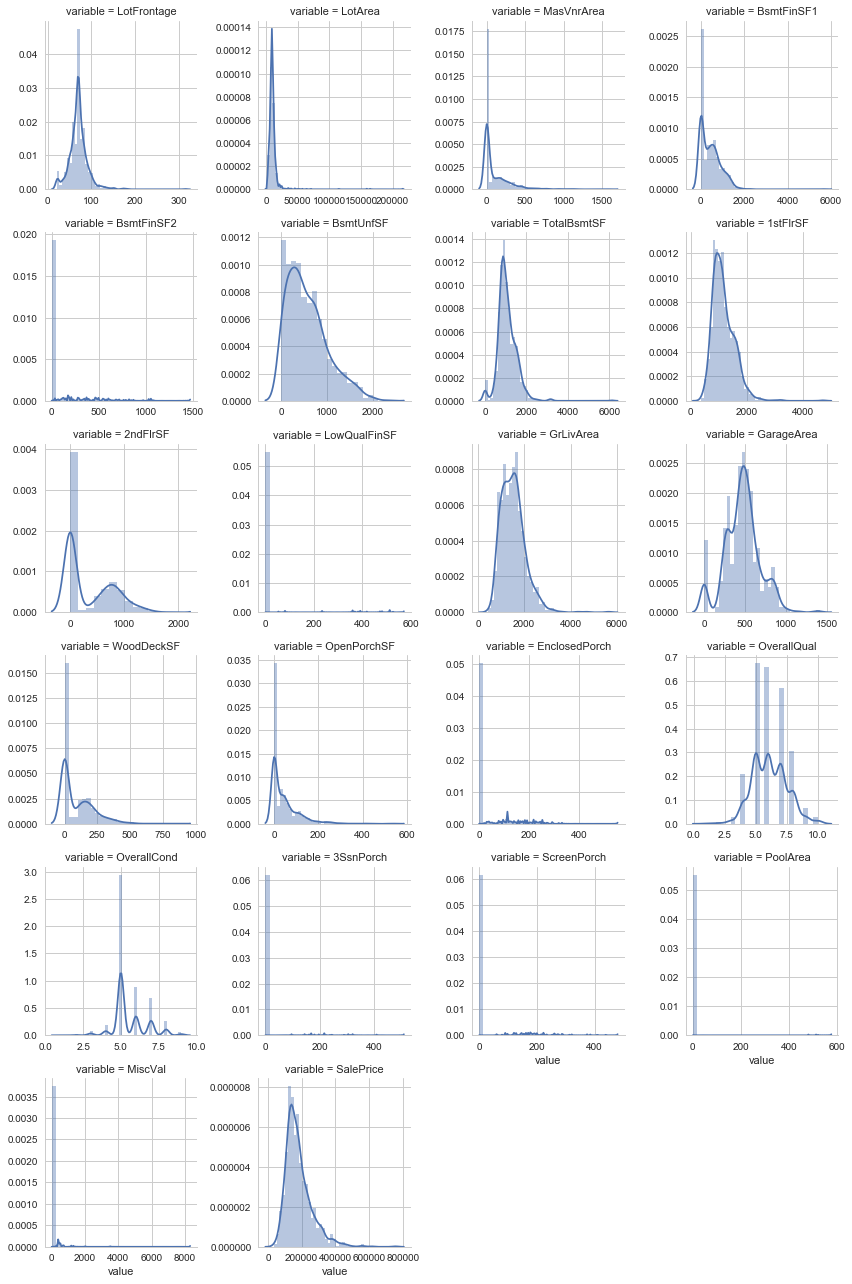

In [13]:
# numeric feature의 value를 분포를 그래프로 시각화하여 확인
f = pd.melt(df, value_vars=cols_real)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show() 

In [14]:
# skewed한 형태의 분포를 갖는 feature를 정규화하기 위해 log값으로 변경

df['BsmtUnfSF'] = np.log(df['BsmtUnfSF'])
df['LotArea'] = np.log(df['LotArea'])

/Users/Dong-hyun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


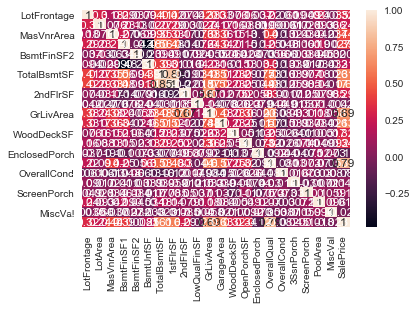

In [15]:
# 모든 numeric feature와 SalePrice의 상관관계를 heatmap으로 확인

corr_real = df_real.corr()
draw = sns.heatmap(corr_real, annot = True)
plt.show(draw)

In [16]:
# SalePrice 와의 # 상관계수만을 출력하여 값 확인

corr_real.SalePrice

LotFrontage      0.324623
LotArea          0.244547
MasVnrArea       0.443575
BsmtFinSF1       0.393596
BsmtFinSF2      -0.000854
BsmtUnfSF        0.206161
TotalBsmtSF      0.613042
1stFlrSF         0.602311
2ndFlrSF         0.285219
LowQualFinSF    -0.024921
GrLivArea        0.686952
GarageArea       0.634201
WoodDeckSF       0.315122
OpenPorchSF      0.338569
EnclosedPorch   -0.119878
OverallQual      0.793883
OverallCond     -0.081510
3SsnPorch        0.045000
ScreenPorch      0.099935
PoolArea         0.017794
MiscVal         -0.022613
SalePrice        1.000000
Name: SalePrice, dtype: float64

In [17]:
# 필터 0.4 이상 -0.4 이하인것
corr_real_fillter = (corr_real.SalePrice > 0.4) | (corr_real.SalePrice < -0.4)
# 상관계수가 0.4이상 -0.4 이하인 변수들
corr_real_use_var = corr_real.loc[corr_real_fillter, corr_real_fillter]
corr_real_use_var.keys()

Index(['MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea',
       'OverallQual', 'SalePrice'],
      dtype='object')

In [18]:
# 상관계수 0.4 이상, -0.4 이하인 feature와 추가적인 정보확인이 필요하다 생각되는 BsmtFinSF1 / PoolArea 를 select  
cols_real_use = ['MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea', 
                 'OverallQual', 'PoolArea', 'SalePrice']
df_real_use = df_real.loc[:, cols_real_use]

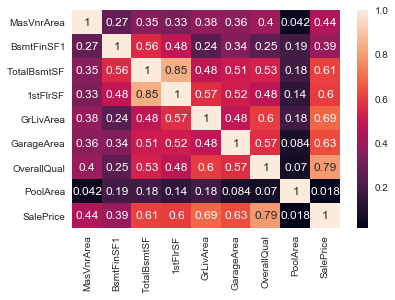

In [19]:
# select 한 numeric feature와 SalePrice의 상관관계를 heatmap으로 확인
corr_real_use = df_real_use.corr()
draw = sns.heatmap(corr_real_use, annot = True)
plt.show(draw)

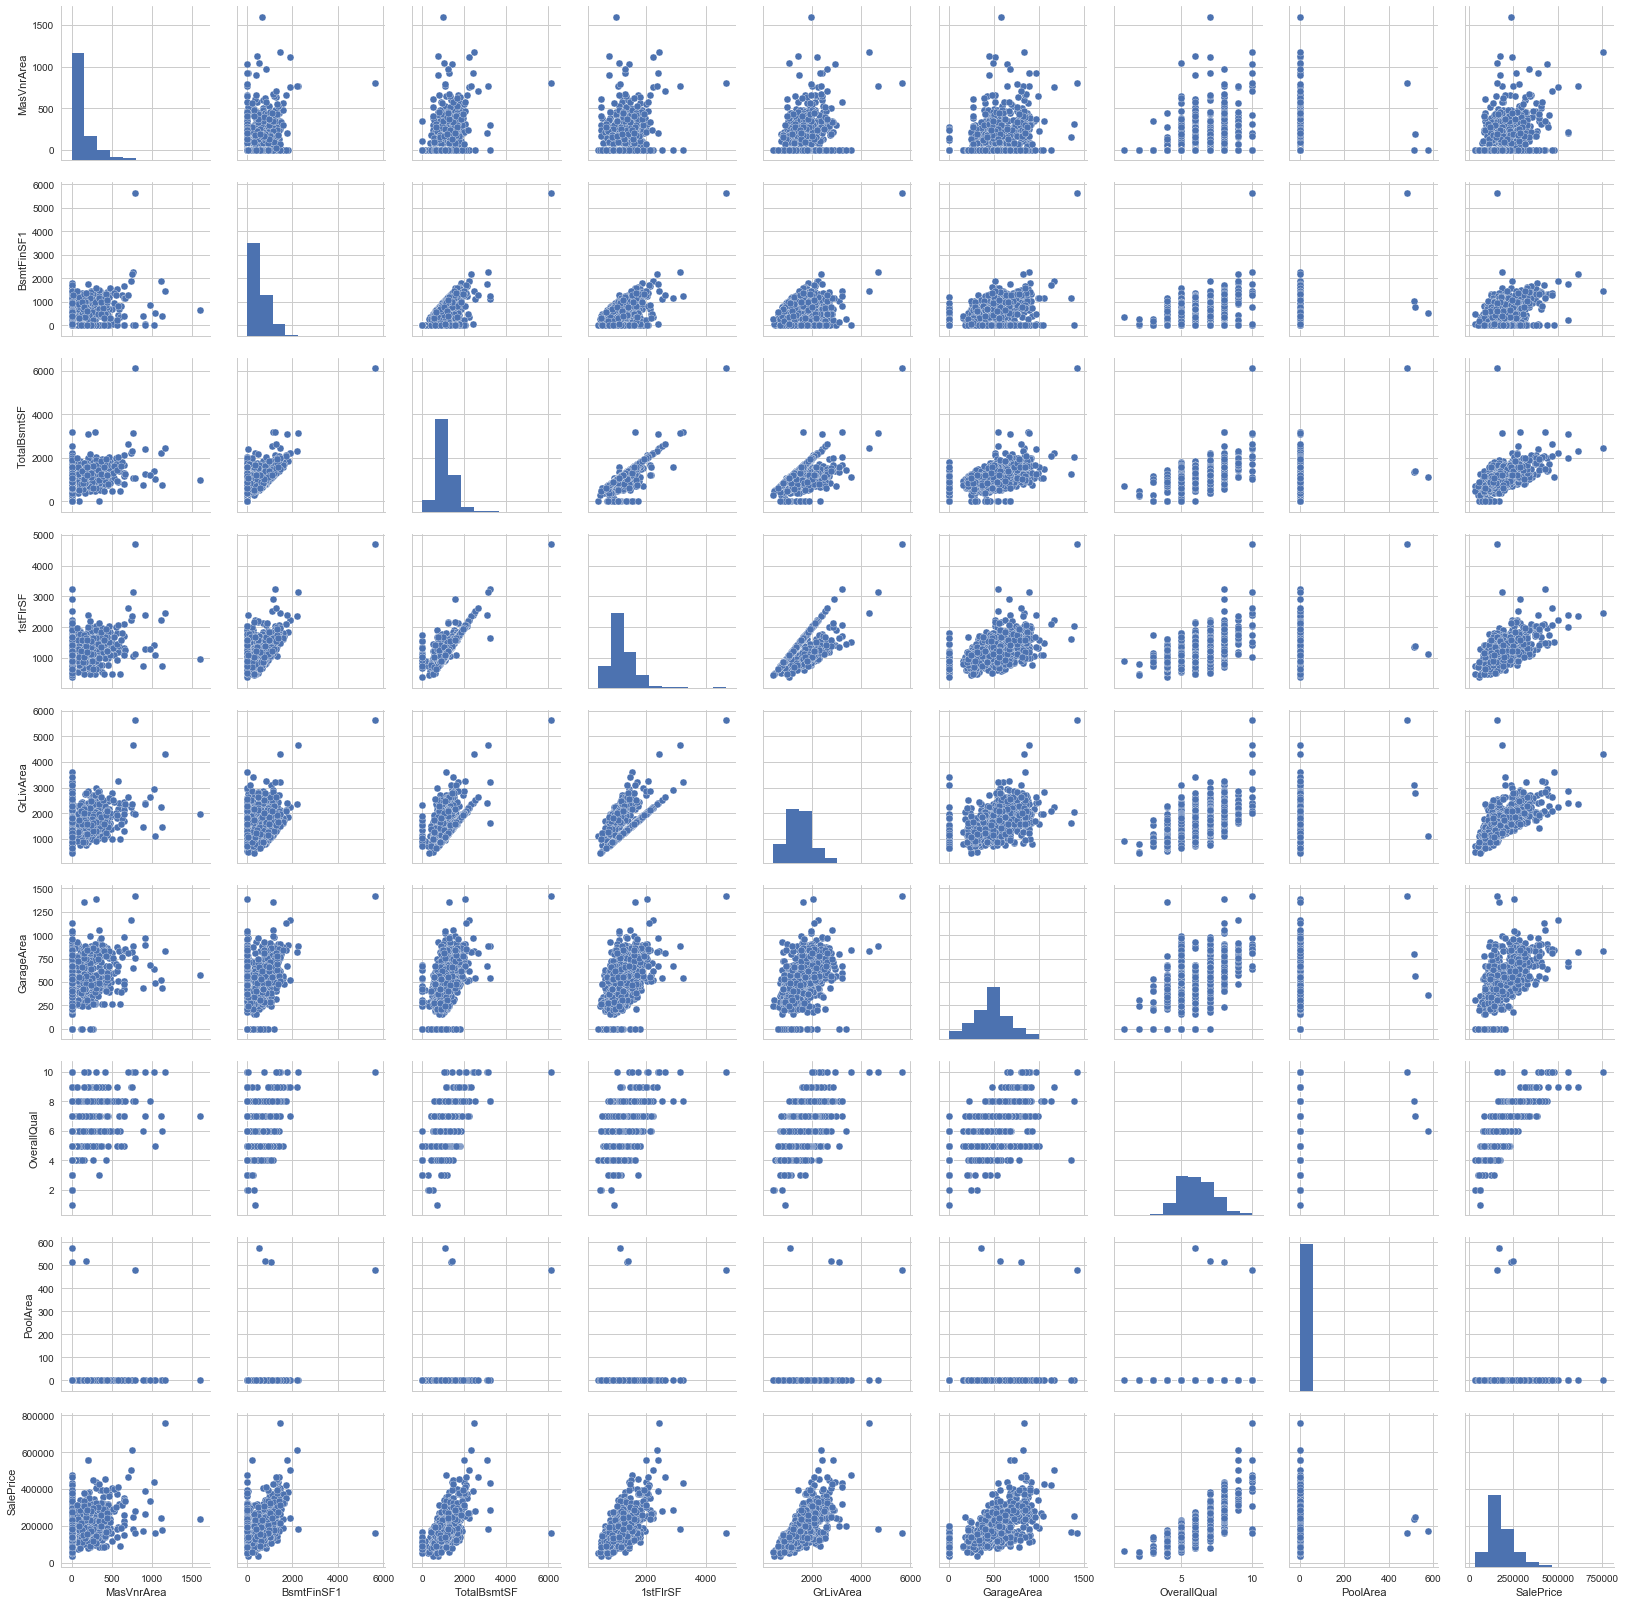

In [20]:
# 각 변수들과의 관계를 산점도를 통해 시각화하여 확인
cols_real_use1 = ['MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea', 
                  'OverallQual', 'PoolArea', 'SalePrice']
df_real_use1 = df_real.loc[:, cols_real_use1]

sns.pairplot(df_real_use1)
plt.show()

### 양적변수 1차 선별결과
* Corelation과 OLS검증의 이중검정을 통해 둘 모두에서 lowvalue로 측정된 변수들을 제외하였음. 
* 위의 과정을 거쳐 남은 Numeric Var는 8개임.
* MasVnrArea, BsmtFinSF1, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageArea, OverallQual, PoolArea
* OverallQual 은 가격과 가장 높은 상관관계를 보이고 있으므로 최우선적으로 사용할 변수임.
* PoolArea는 데이터 자체는 적지만, 
* MasVnrArea 는 상관관계는 보통이거나 비교적 낮지만 다른 문제점이 특별히 보이지 않으므로 일단 사용할 예정임. 추가적인 검토를 통해 배제 가능함.


### 과제
* TotalBsmtSF, 1stFlrSF, GrLivArea,들은 독립변수 서로간의 상관관계가 지나치게 높음. 
* 이 변수들 중 배제할 것과 가공하여 사용할 것을 정할 필요 있음. 

# Numeric Value(갯수, 연도)

* Categoricla feature 중 Nemeric value를 갖는 feature를 구분

In [21]:
# Nemeric value를 갖고 있지만 갯수, 연도를 나타내는 feature 또한 categorical feature로 지정했을 DataFrame을 통해 확인

cols_cat = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
            'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle','RoofStyle', 'RoofMatl', 'Exterior1st', 
            'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 
            'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', "GarageYrBlt", 
            "GarageCars", "GarageType", 'Fireplaces', "PavedDrive", "MiscFeature", "MoSold", "YrSold", "SaleType", "SaleCondition"]

dfX_cat = pd.DataFrame(df, columns = cols_cat)
dfX_cat.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,GarageCars,GarageType,Fireplaces,PavedDrive,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,1,0,2,1,3,1,8,2003,2003,2003.0,2,Attchd,0,Y,NaN,2,2008,WD,Normal
1,20,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Y,SBrkr,0,1,2,0,3,1,6,1976,1976,1976.0,2,Attchd,1,Y,NaN,5,2007,WD,Normal
2,60,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,1,0,2,1,3,1,6,2001,2002,2001.0,2,Attchd,1,Y,NaN,9,2008,WD,Normal
3,70,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,SBrkr,1,0,1,0,3,1,7,1915,1970,1998.0,3,Detchd,1,Y,NaN,2,2006,WD,Abnorml
4,60,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,1,0,2,1,4,1,9,2000,2000,2000.0,3,Attchd,1,Y,NaN,12,2008,WD,Normal


In [22]:
df_real_cat = dfX_cat.select_dtypes(include=[np.number])
df_real_cat.keys()

Index(['MSSubClass', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'GarageYrBlt', 'GarageCars', 'Fireplaces', 'MoSold',
       'YrSold'],
      dtype='object')

In [23]:
cols_real_cat = ['MSSubClass', 'YearBuilt', 'YearRemodAdd','BsmtFullBath', 'BsmtHalfBath', 
                 'FullBath', 'HalfBath', 'BedroomAbvGr','KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
                 'GarageYrBlt', 'MoSold', 'YrSold']
df_real_cat.tail()

,MSSubClass,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,GarageCars,Fireplaces,MoSold,YrSold
Id,,,,,,,,,,,,,,,
1025,90,0,0,2,2,4,2,8,1974,1974,NaN,0,0,9,2009
1026,20,0,0,2,0,3,1,7,2008,2009,2008.0,3,1,5,2009
1027,20,0,0,1,0,3,1,6,2006,2006,NaN,0,0,7,2006
1028,20,1,0,2,0,2,1,6,2004,2005,2004.0,2,0,10,2009
1029,20,1,0,1,0,2,1,5,1950,1996,1950.0,1,0,4,2010


In [24]:
df_real_cat_sale = pd.concat([df_real_cat, dfy], axis=1)
df_real_cat_sale.tail()

,MSSubClass,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,GarageCars,Fireplaces,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,
1025,90,0,0,2,2,4,2,8,1974,1974,NaN,0,0,9,2009,136000
1026,20,0,0,2,0,3,1,7,2008,2009,2008.0,3,1,5,2009,287090
1027,20,0,0,1,0,3,1,6,2006,2006,NaN,0,0,7,2006,84500
1028,20,1,0,2,0,2,1,6,2004,2005,2004.0,2,0,10,2009,185000
1029,20,1,0,1,0,2,1,5,1950,1996,1950.0,1,0,4,2010,142125


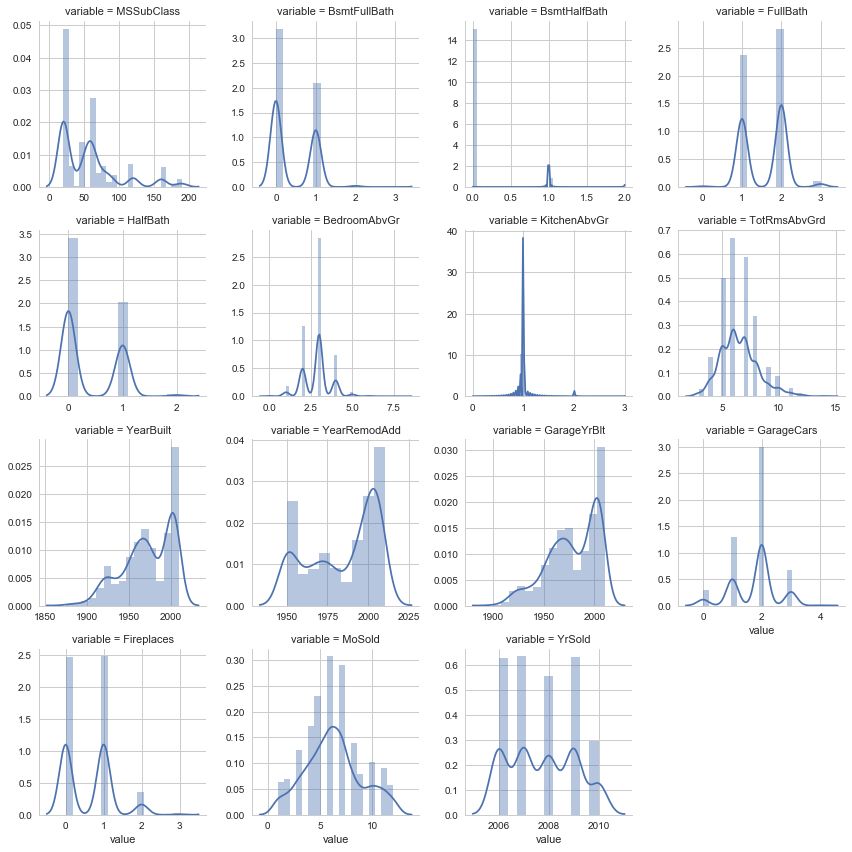

In [25]:
# 분포를 그래프로 시각화
f = pd.melt(df_real_cat)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()

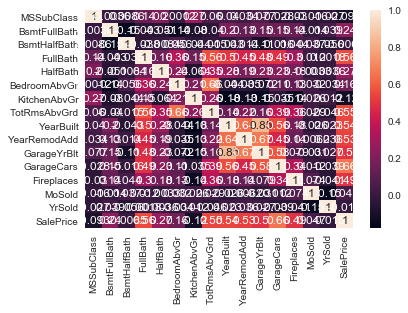

In [26]:
df_real_cat_corr = df_real_cat_sale.corr()
draw = sns.heatmap(df_real_cat_corr, annot = True)
plt.show(draw)

In [27]:
# SalePrice 와의 상관계수만 따로 모음
df_real_cat_corr.SalePrice

MSSubClass     -0.092854
BsmtFullBath    0.244673
BsmtHalfBath   -0.006512
FullBath        0.558027
HalfBath        0.267535
BedroomAbvGr    0.162079
KitchenAbvGr   -0.121669
TotRmsAbvGrd    0.546666
YearBuilt       0.544651
YearRemodAdd    0.527009
GarageYrBlt     0.497936
GarageCars      0.657427
Fireplaces      0.494997
MoSold          0.047261
YrSold         -0.015135
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [28]:
# 필터 0.4 이상 -0.4 이하인것
corr_real_cat_fillter = (df_real_cat_corr.SalePrice > 0.4) | (df_real_cat_corr.SalePrice < -0.4)
# 상관계수가 0.4이상 -0.4 이하인 변수들
corr_real_cat_use_var = df_real_cat_corr.loc[corr_real_cat_fillter, corr_real_cat_fillter]

# 사용할 변수 리스트
cols_real_cat_use = list(corr_real_cat_use_var.keys())
cols_real_cat_use

['FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'GarageCars',
 'Fireplaces',
 'SalePrice']

In [29]:
# 필터 적용된 변수들의 df
df_real_cat_use = df.loc[:, cols_real_cat_use]
df_real_cat_use.tail()

,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,GarageCars,Fireplaces,SalePrice
Id,,,,,,,,
1025,2,8,1974,1974,NaN,0,0,136000
1026,2,7,2008,2009,2008.0,3,1,287090
1027,1,6,2006,2006,NaN,0,0,84500
1028,2,6,2004,2005,2004.0,2,0,185000
1029,1,5,1950,1996,1950.0,1,0,142125


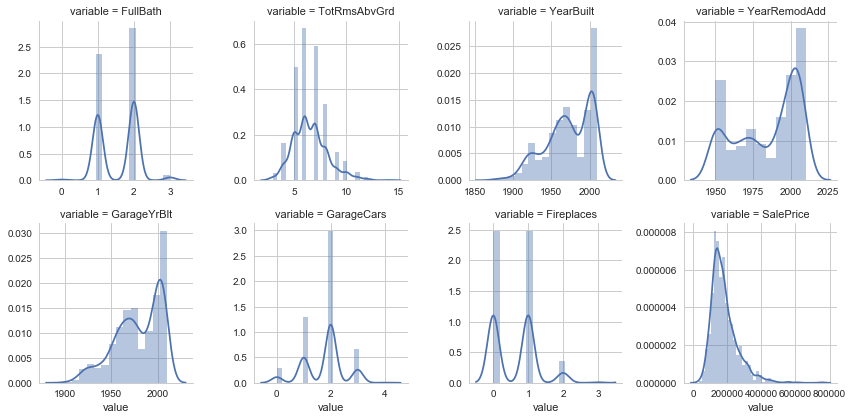

In [30]:
f = pd.melt(df_real_cat_use)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()

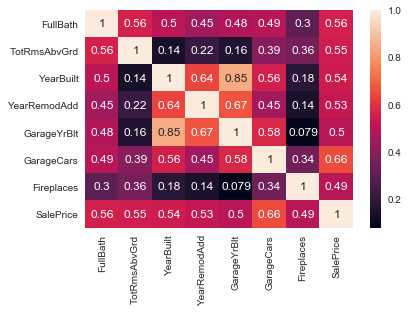

In [31]:
df_real_cat_corr1 = df_real_cat_use.corr()
draw = sns.heatmap(df_real_cat_corr1, annot = True)
plt.show(draw)

### 질적변수-Numeric 1차 선택결과

* 7개 : YearBuilt, YearRemodAdd, FullBath, TotRmsAbvGrd, Fireplaces, GarageCars, GarageYrBlt
* 개념상 YearRemodAdd 는 YearBuilt 의 업데이트 변수이다. 당연히 양자의 상관관계는 0.8 에 달한다. 따라서 YearBuilt를 배제하는 것을 생각할 필요가 있다. 
* GarageYrBlt 도 YearBuilt와 YearRemodAdd 와 높은 상관성을 보이는데, 이는 개념상 건축연도와 차고건축연도가 일치하는 것이 자연스럽고, 독립변수간의 독립성을 지키기 위해서 GarageYrBlt를 배제하는 것을 고려할 필요가 있을듯 하다.
* GarageCars(0.66) 는 개념상 실수변수인 GarageArea(0.63) 와 거의 같은 것을 설명하는 것이다. 당연히 높은 상관성을 보일 것이고, 둘 중 하나만 있어도 관련내용을 설명할 수 있을 것이다. 따라서 활용하기 용이한 실수변수를 사용하고 ols 결과의 std err가 높은, GarageCars를 배제하는 것이 좋을 것이다. 
* 이상의 내용을 적용하면 4개의 변수가 남는다.
* YearRemodAdd, FullBath, TotRmsAbvGrd, Fireplaces

## 인코딩이 필요한 카테고리 변수(등급)


In [32]:
cols_condition = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
                  'KitchenQual', 'Functional', "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence"]

In [33]:
grade_col=['ExterQual','ExterCond','BsmtQual','BsmtCond', 'HeatingQC', 'KitchenQual', "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]
df[grade_col] = df[grade_col].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po','NA'], [5,4,3,2,1,0]).fillna(0)
df['BsmtExposure'] = df['BsmtExposure'].replace(['Gd', 'Av', 'Mn', 'No', 'Na'],[4,3,2,1,0]).fillna(0)
df[['BsmtFinType1', 'BsmtFinType2']] = df[['BsmtFinType1', 'BsmtFinType2']].replace(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ','Unf', 'NA'],[6,5,4,3,2,1,0]).fillna(0)
df['Functional'] = df['Functional'].replace(['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],[7,6,5,4,3,2,1,0]).fillna(0)
df["GarageFinish"] = df["GarageFinish"].replace(['Fin', 'RFn', 'Unf', 'NA'],[3,2,1,0]).fillna(0)
df["Fence"] = df["Fence"].replace(['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA' ],[4,3,2,1,0]).fillna(0)

In [34]:
null_count = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
null_count.head(6)

,0
MiscFeature,997
Alley,971
GarageYrBlt,57
GarageType,57
MasVnrType,4
Electrical,1


In [35]:
df_condition = df[cols_condition]
df_condition.tail()

,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence
Id,,,,,,,,,,,,,,,,
1025,3,3,4.0,3.0,1.0,1.0,1.0,3,3,7,0.0,0.0,0.0,0.0,0.0,0.0
1026,4,3,4.0,3.0,1.0,1.0,1.0,5,5,7,4.0,3.0,3.0,3.0,0.0,0.0
1027,3,3,4.0,3.0,1.0,1.0,1.0,5,3,7,0.0,0.0,0.0,0.0,0.0,0.0
1028,4,3,4.0,3.0,1.0,6.0,1.0,5,4,7,0.0,2.0,3.0,3.0,0.0,0.0
1029,3,3,3.0,3.0,2.0,6.0,3.0,4,4,7,0.0,1.0,3.0,3.0,0.0,0.0


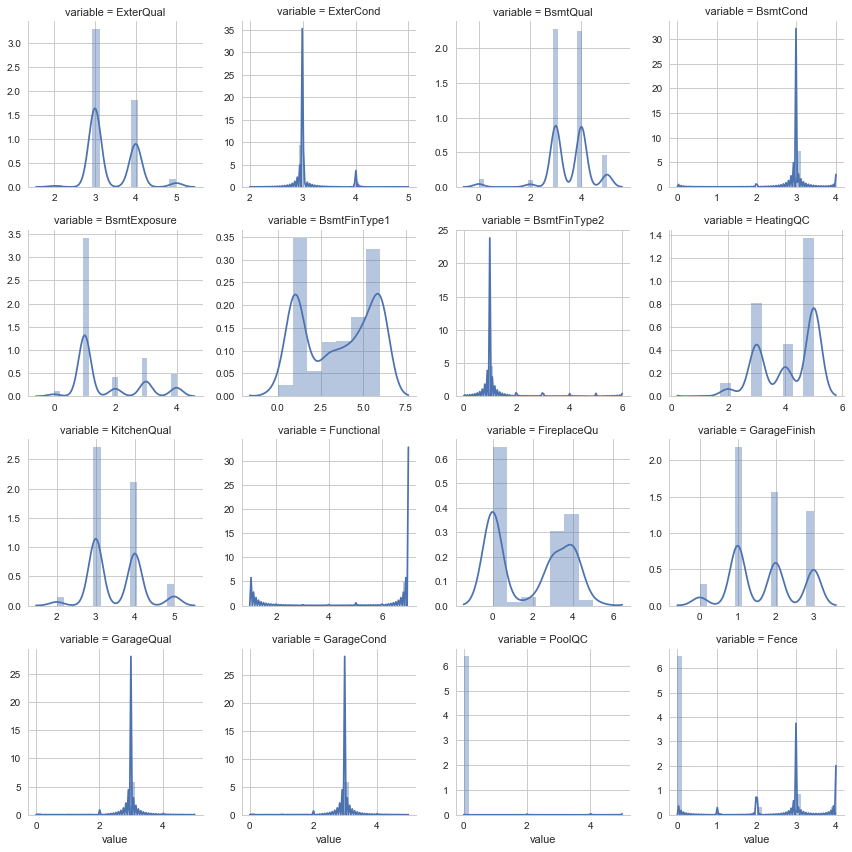

In [36]:
# 분포를 그래프로 시각화
f = pd.melt(df_condition, value_vars=cols_condition)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()

# 대부분의 등급이 같은 변수를 제외시킬수 있을까?

In [37]:
df_condition = pd.concat([df_condition, dfy], axis=1)

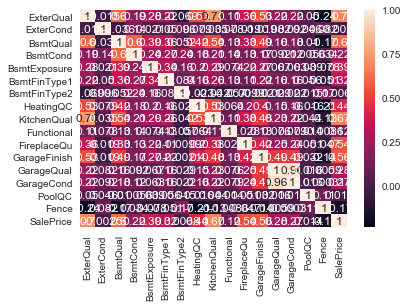

In [38]:
corr_condition = df_condition.corr()
draw = sns.heatmap(corr_condition, annot = True)
plt.show(draw)

In [39]:
# SalePrice 와의 상관계수만 따로 모음
corr_condition.SalePrice

ExterQual       0.696650
ExterCond      -0.002537
BsmtQual        0.604226
BsmtCond        0.221733
BsmtExposure    0.391959
BsmtFinType1    0.323736
BsmtFinType2    0.006838
HeatingQC       0.436776
KitchenQual     0.674052
Functional      0.122261
FireplaceQu     0.542134
GarageFinish    0.560317
GarageQual      0.280267
GarageCond      0.268731
PoolQC          0.014139
Fence          -0.167278
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [40]:
# 필터 0.4 이상 -0.4 이하인것
corr_condition_fillter = (corr_condition.SalePrice > 0.4) | (corr_condition.SalePrice < -0.4)
# 상관계수가 0.4이상 -0.4 이하인 변수들
corr_condition_use_var = corr_condition.loc[corr_condition_fillter, corr_condition_fillter]
corr_condition_use_var.keys()

Index(['ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
       'GarageFinish', 'SalePrice'],
      dtype='object')

In [41]:
cols_condition_use = corr_condition_use_var.keys()
df_condition_use = df.loc[:, cols_condition_use]

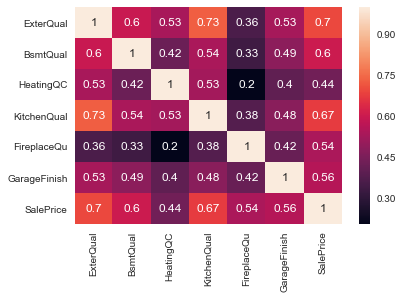

In [42]:
corr_condition_use = df_condition_use.corr()
draw = sns.heatmap(corr_condition_use, annot = True)
plt.show(draw)

In [43]:
# 필터 적용된 변수들의 df
df_condition_use.tail()

,ExterQual,BsmtQual,HeatingQC,KitchenQual,FireplaceQu,GarageFinish,SalePrice
Id,,,,,,,
1025,3,4.0,3,3,0.0,0.0,136000
1026,4,4.0,5,5,4.0,3.0,287090
1027,3,4.0,5,3,0.0,0.0,84500
1028,4,4.0,5,4,0.0,2.0,185000
1029,3,3.0,4,4,0.0,1.0,142125


### 인코딩이 필요한 카테고리 변수(등급) 1차 선별결과

* 6개의 변수 선별 : 'ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish'
* 개념상 다른 부분의 등급들이 때문에 서로 상관관계가 높게 나온것은 우연의 일치로 높게나왔다고 판단됨

### 과제
* 6개의 변수들중 더 줄일수 있는것이 있을지 판단해봐야함

# 상관관계가 높은 변수 처리
+ 어떤 변수를 선택해야할지 vif방식으로 결정
  + TotalBsmtSF, 1stFlrSF, GrLivArea 
  + YearBuilt, YearRemodAdd
  + GarageArea, GarageCars


In [44]:
# GrLivArea, YearRemodAdd, GarageArea 선택됨
cols_choice = ['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'YearBuilt', 'YearRemodAdd', 'GarageArea', 'GarageCars']
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df[cols_choice].values, i) for i in range(df[cols_choice].shape[1])]
vif["features"] = df[cols_choice].columns
vif

,VIF Factor,features
0,25.088330,TotalBsmtSF
1,39.788449,1stFlrSF
2,15.849495,GrLivArea
3,8890.726764,YearBuilt
4,8791.823280,YearRemodAdd
5,29.254651,GarageArea
6,31.541116,GarageCars


# 질적 변수

In [45]:
# 카테고리 변수
cols_cat = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
            'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle','RoofStyle', 'RoofMatl', 'Exterior1st', 
            'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 
            "GarageType", "PavedDrive", "MiscFeature", "SaleType", "SaleCondition"]

df_cat = df[cols_cat]

df_cats = pd.concat([df_cat, dfy], axis=1)

In [46]:
df_cat = dfX_cat.select_dtypes(include=[np.object])
print(df_cat.keys())
print(len(df_cat.keys()))

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
       'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')
27


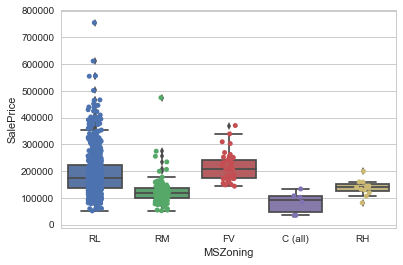

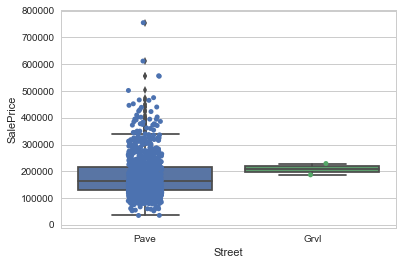

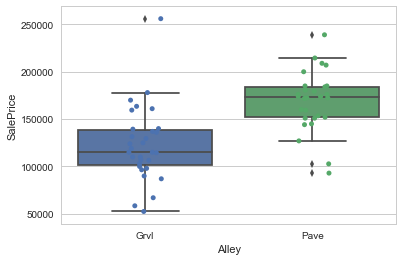

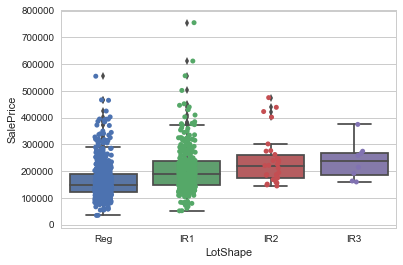

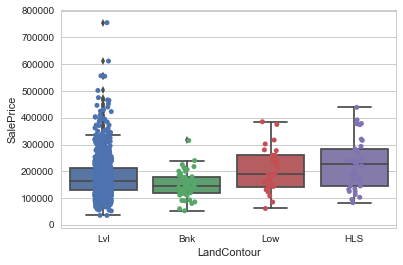

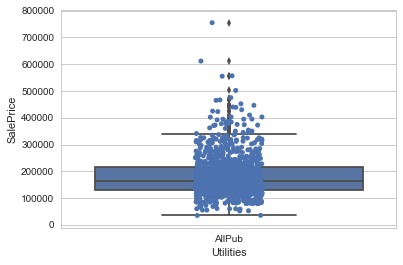

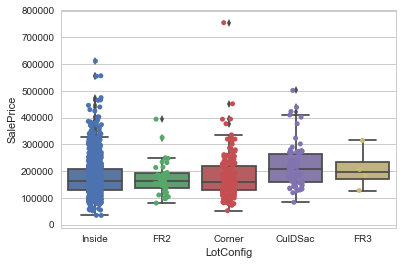

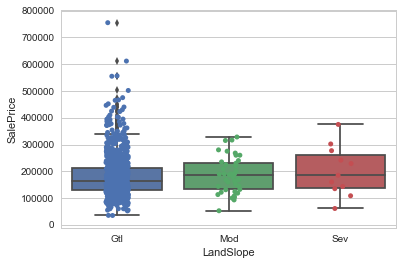

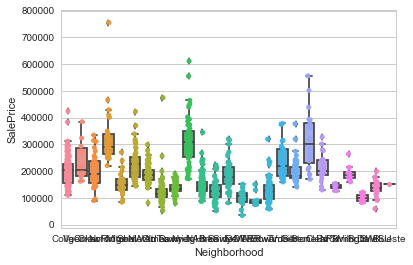

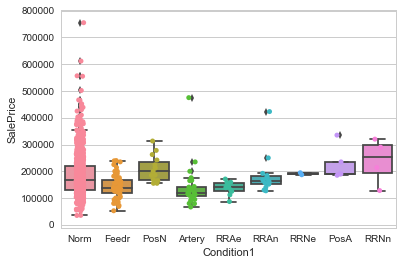

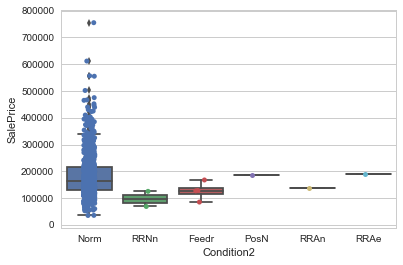

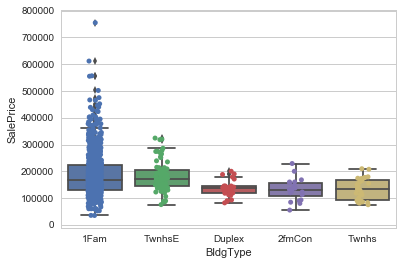

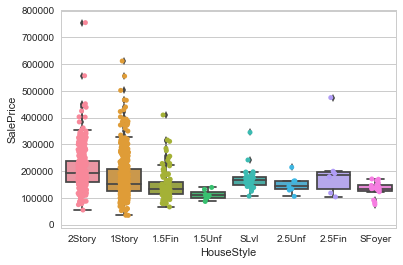

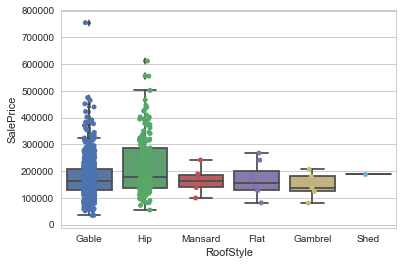

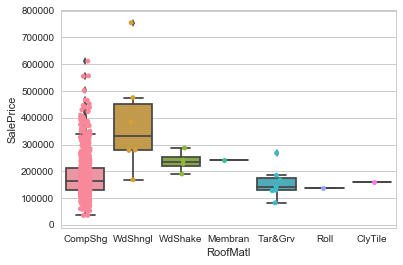

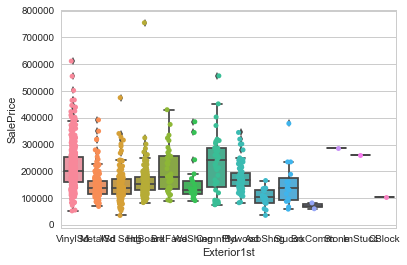

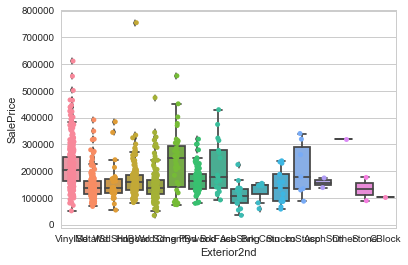

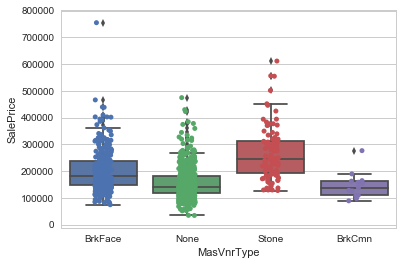

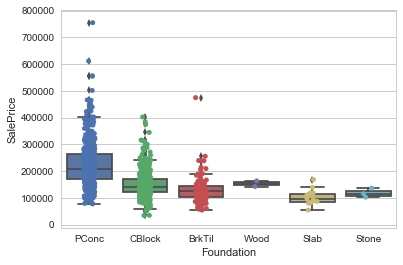

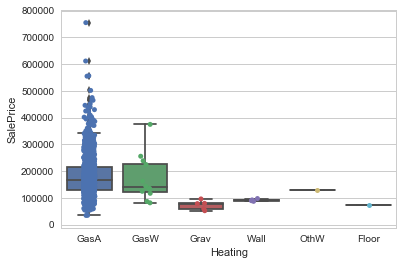

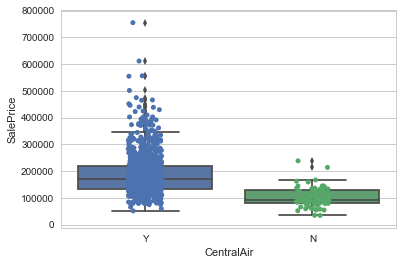

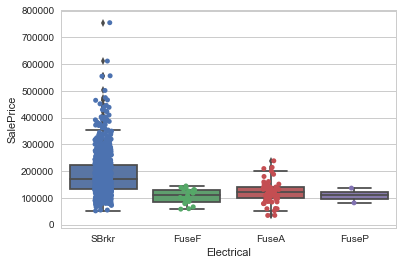

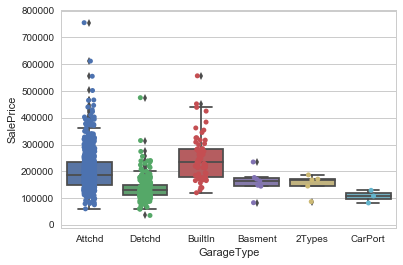

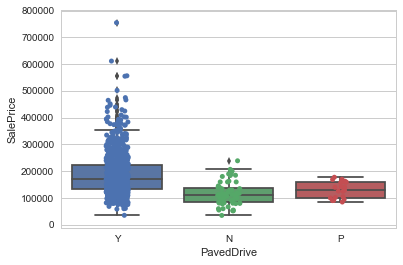

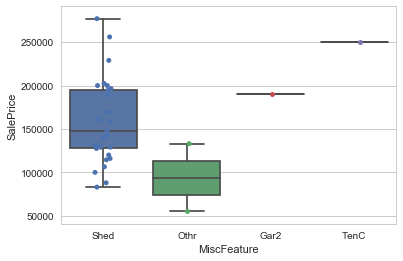

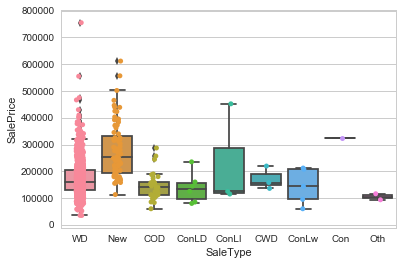

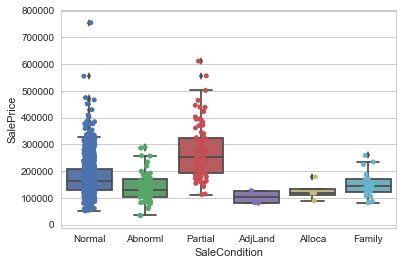

In [47]:
for cat in df_cat:
    sns.boxplot(x=cat, y="SalePrice", data=df)
    sns.stripplot(x=cat, y="SalePrice", data=df, jitter=True)
    plt.show()

변수별 $R^{2}$ 값 확인

In [48]:
for cat in cols_cat:
    a = "SalePrice ~ C(" + cat + ") + 0"
    model = sm.OLS.from_formula(a , df_cats)
    result = model.fit()
    print(cat, ':', result.rsquared)

MSZoning : 0.114221656507
Street : 0.000220925382656
Alley : 0.305132881062
LotShape : 0.0814279993606
LandContour : 0.0222989551333
Utilities : 1.11022302463e-16
LotConfig : 0.018339364863
LandSlope : 0.000883543949794
Neighborhood : 0.545321007018
Condition1 : 0.0309273954381
Condition2 : 0.00455547743166
BldgType : 0.0326995376125
HouseStyle : 0.0769347400566
RoofStyle : 0.0532498127026
RoofMatl : 0.0455029964315
Exterior1st : 0.176653478164
Exterior2nd : 0.178283626472
MasVnrType : 0.194412328796
Foundation : 0.250778679025
Heating : 0.0170449298394
CentralAir : 0.0696379758491
Electrical : 0.0624188431006
GarageType : 0.203197044012
PavedDrive : 0.0552714293739
MiscFeature : 0.206843638935
SaleType : 0.148142365884
SaleCondition : 0.152190288187


In [49]:
# 'Alley' 는 nan값이 너무많음
anova_cat = ['Neighborhood', 'Foundation']
for cat in anova_cat:
    a = "SalePrice ~ C(" + cat + ")"
    model = sm.OLS.from_formula(a , df_cats)
    result = model.fit()
    print(result.summary(), '\n')


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     50.22
Date:                Wed, 25 Oct 2017   Prob (F-statistic):          1.89e-153
Time:                        10:32:52   Log-Likelihood:                -12658.
No. Observations:                1030   AIC:                         2.537e+04
Df Residuals:                    1005   BIC:                         2.549e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

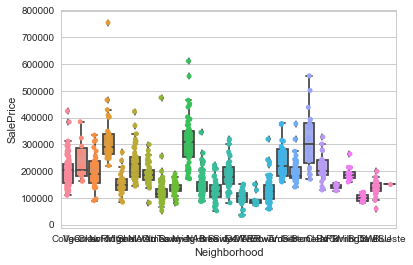

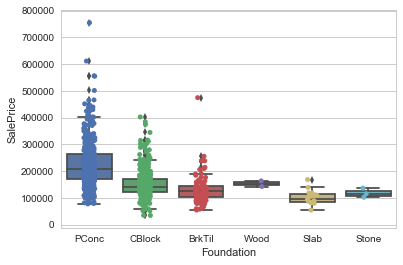

In [50]:
for cat in anova_cat:
    sns.boxplot(x=cat, y="SalePrice", data=df)
    sns.stripplot(x=cat, y="SalePrice", data=df, jitter=True)
    plt.show()

### Cat-Str 1차 분석결과

* ANOVA 검증을 통해 [ R-squared > 0.5 ] 와  [ Prob(F) < e-100 ] 를 기준으로 선별한 결과, 2개의 변수를 선택하였다. 
* Neighborhood (R-squared = 0.54, Prob(F) = 3.12e-166)
* Foundation (R-squared = 0.29, Prob(F) = 5.01e-74) 

# Feature Selection 결과

* 양적변수 5개 : OverallQual, PoolArea, MasVnrArea, GrLivArea, GarageArea


* 질적변수-갯수,연도 4개 : YearRemodAdd, FullBath, TotRmsAbvGrd, Fireplaces


* 질적변수-등급  6개 : ExterQual, BsmtQual, HeatingQC, KitchenQual, FireplaceQu, GarageFinish


* 질적변수 2개 : Neighborhood, Foundation 



# Modeling(OLS Regression)

In [51]:
# 1차 feature selection 한 변수 구분
select_feat = ['OverallQual', 'PoolArea', 'MasVnrArea', 'GrLivArea', 'Neighborhood', 'Foundation', 'ExterQual', 'BsmtQual', 'GarageArea',
               'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'YearRemodAdd', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces']
df_sel = df[select_feat]
df_sels = pd.concat([df_sel, dfy], axis=1)
df_sels.head()

,OverallQual,PoolArea,MasVnrArea,GrLivArea,Neighborhood,Foundation,ExterQual,BsmtQual,GarageArea,HeatingQC,KitchenQual,FireplaceQu,GarageFinish,YearRemodAdd,FullBath,TotRmsAbvGrd,Fireplaces,SalePrice
Id,,,,,,,,,,,,,,,,,,
0,7,0,196.0,1710,CollgCr,PConc,4,4.0,548,5,4,0.0,2.0,2003,2,8,0,208500
1,6,0,0.0,1262,Veenker,CBlock,3,4.0,460,5,3,3.0,2.0,1976,2,6,1,181500
2,7,0,162.0,1786,CollgCr,PConc,4,4.0,608,5,4,3.0,2.0,2002,2,6,1,223500
3,7,0,0.0,1717,Crawfor,BrkTil,3,3.0,642,4,4,4.0,1.0,1970,1,7,1,140000
4,8,0,350.0,2198,NoRidge,PConc,4,4.0,836,5,4,3.0,2.0,2000,2,9,1,250000


In [52]:
# 1차 selection 한 변수의 ols
result_sel = sm.OLS.from_formula("np.log(SalePrice) ~ OverallQual + PoolArea + MasVnrArea + GrLivArea + C(Neighborhood) + C(Foundation) +"
                                 "ExterQual + BsmtQual + HeatingQC + KitchenQual + FireplaceQu + GarageFinish + GarageArea + "
                                 "YearRemodAdd + FullBath + TotRmsAbvGrd + Fireplaces", df_sels).fit()
print(result_sel.summary())
# P>|t| 값이 높은 변수들이 아직 많음!

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     142.8
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        10:32:53   Log-Likelihood:                 520.73
No. Observations:                1030   AIC:                            -951.5
Df Residuals:                     985   BIC:                            -729.3
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

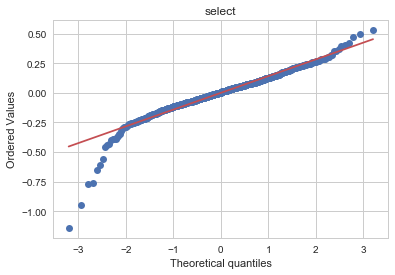

In [53]:
# 정규성을 QQ plot으로 확인해자 
sp.stats.probplot(result_sel.resid, plot=plt)
plt.title('select')  
plt.show()

In [54]:
# 정규성 검정 -> 당연히 0.000 
test = sms.omni_normtest(result_sel.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 305.579
P-value     :  0.000


In [55]:
# MasVnrArea 변수 제거
model_sel2  = sm.OLS.from_formula("np.log(SalePrice) ~ OverallQual + PoolArea + GrLivArea + C(Neighborhood) + C(Foundation) +"
                                 "ExterQual + BsmtQual + HeatingQC + KitchenQual + FireplaceQu + GarageFinish + YearRemodAdd + "
                                 "FullBath + TotRmsAbvGrd + Fireplaces + GarageArea", df_sels)
result_sel2 = model_sel2.fit()
print(result_sel2.summary())
# P>|t| 값이 높은 변수들이 아직 많음!

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     146.2
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        10:32:53   Log-Likelihood:                 520.66
No. Observations:                1030   AIC:                            -953.3
Df Residuals:                     986   BIC:                            -736.1
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [56]:
# FireplaceQu 제거, Foundation 제거
R_style = "np.log(SalePrice) ~ scale(OverallQual) + scale(PoolArea) + scale(GrLivArea) + C(Neighborhood) + \
                                 scale(BsmtQual) + scale(KitchenQual) + scale(GarageFinish) + scale(YearRemodAdd) + \
                                 scale(TotRmsAbvGrd) + scale(Fireplaces) + scale(GarageArea)"
model_sel2  = sm.OLS.from_formula(R_style, df_sels)

result_sel2 = model_sel2.fit()
print(result_sel2.summary())
# P>|t| 값이 높은 변수들이 아직 많음!

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     181.8
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        10:32:53   Log-Likelihood:                 509.18
No. Observations:                1030   AIC:                            -948.4
Df Residuals:                     995   BIC:                            -775.6
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [57]:
# Cross-Validation을 통해 rmse값 확인
outcome, predictors = patsy.dmatrices(R_style, df_sels)
model_cross = LinearRegression()
cv = KFold(n_splits=10, shuffle=True, random_state=0)
rmse1 = np.sqrt(-cross_val_score(model_cross, predictors, outcome, scoring="neg_mean_squared_error", cv=cv))
rmse1

array([ 0.17760372,  0.14530284,  0.22201729,  0.18407413,  0.13813123,
        0.1502745 ,  0.14084951,  0.14414203,  0.13490731,  0.11643489])

In [58]:
rmse1.mean()

0.15537374425124889

In [59]:
# PoolArea 정규성 위해서 제거
R_style = "np.log(SalePrice) ~ scale(OverallQual) + scale(GrLivArea) + C(Neighborhood) + \
                                 scale(BsmtQual) + scale(KitchenQual) + scale(GarageFinish) + scale(YearRemodAdd) + \
                                 scale(TotRmsAbvGrd) + scale(Fireplaces) + scale(GarageArea)"

model_sel2  = sm.OLS.from_formula(R_style, df_sels)

result_sel2 = model_sel2.fit()
print(result_sel2.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     182.3
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        10:32:54   Log-Likelihood:                 496.58
No. Observations:                1030   AIC:                            -925.2
Df Residuals:                     996   BIC:                            -757.3
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [60]:
# Cross-Validation을 통해 rmse값 확인
outcome, predictors = patsy.dmatrices(R_style, df_sels)
model_cross = LinearRegression()
cv = KFold(n_splits=10, shuffle=True, random_state=0)
rmse2 =np.sqrt(-cross_val_score(model_cross, predictors, outcome, scoring="neg_mean_squared_error", cv=cv))
rmse2

array([ 0.15783049,  0.14111653,  0.22571515,  0.18184552,  0.13994902,
        0.15110291,  0.14098337,  0.1455198 ,  0.13379029,  0.11828733])

In [61]:
rmse2.mean()

0.1536140402452581

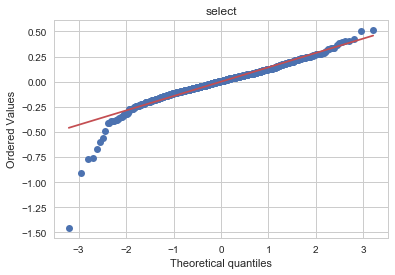

In [62]:
sp.stats.probplot(result_sel2.resid, plot=plt)
plt.title('select')  
plt.show()

In [63]:
# ols로 제거할수있는 변수 모두 제거
select2_feat = ['OverallQual', 'GrLivArea', 'Neighborhood', 'BsmtQual', 'KitchenQual', 
               'GarageFinish', 'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'SalePrice']

In [64]:
df_sel2 = df[select2_feat]
df_sel2.head()

,OverallQual,GrLivArea,Neighborhood,BsmtQual,KitchenQual,GarageFinish,YearRemodAdd,TotRmsAbvGrd,Fireplaces,GarageArea,SalePrice
Id,,,,,,,,,,,
0,7,1710,CollgCr,4.0,4,2.0,2003,8,0,548,208500
1,6,1262,Veenker,4.0,3,2.0,1976,6,1,460,181500
2,7,1786,CollgCr,4.0,4,2.0,2002,6,1,608,223500
3,7,1717,Crawfor,3.0,4,1.0,1970,7,1,642,140000
4,8,2198,NoRidge,4.0,4,2.0,2000,9,1,836,250000


In [65]:
df_sel2[ df_sel2['Neighborhood'] == 'Blueste']['Neighborhood'].index

Int64Index([429], dtype='int64', name='Id')

In [66]:
# 레버리지가 큰 아웃라이어 판별
influence = result_sel2.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(dfy) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]

In [67]:
# 레버리지가큰 아웃라이어 변수 index리스트
idx = [3,   18,   37,  131,  158,  199,  212,  225,  265,  299,  318, 329,  345,  359,  367,  378,  391,  416,  419,  437,  453, 455, 
       456,  458,  474,  477,  482,  486,  490,  494,  497,  500, 508,  513,  515,  525,  533,  577,  643,  657,  658,  717,  719, 725,  
       733,  734,  747,  749,  772,  920,  924,  944,  946,  951, 983, 1019, 1027]

In [68]:
# 레버리지가큰 아웃라이어 drop
df_sel2.drop(df.index[[idx]], inplace=True)

/Users/Dong-hyun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [69]:
df_sel2.head()

,OverallQual,GrLivArea,Neighborhood,BsmtQual,KitchenQual,GarageFinish,YearRemodAdd,TotRmsAbvGrd,Fireplaces,GarageArea,SalePrice
Id,,,,,,,,,,,
0,7,1710,CollgCr,4.0,4,2.0,2003,8,0,548,208500
1,6,1262,Veenker,4.0,3,2.0,1976,6,1,460,181500
2,7,1786,CollgCr,4.0,4,2.0,2002,6,1,608,223500
4,8,2198,NoRidge,4.0,4,2.0,2000,9,1,836,250000
5,5,1362,Mitchel,4.0,3,1.0,1995,5,0,480,143000


In [86]:
# 레버리지가 큰 아웃라이어를 제거한 모델
R_style = "np.log(SalePrice) ~ scale(OverallQual) + scale(GrLivArea) + C(Neighborhood) +  \
                                 scale(BsmtQual) + scale(KitchenQual) + scale(GarageFinish) + scale(YearRemodAdd) + \
                                 scale(TotRmsAbvGrd) + scale(Fireplaces)+ scale(GarageArea)"

model_sel3  = sm.OLS.from_formula(R_style, df_sel2)

result_sel3 = model_sel3.fit()
print(result_sel3.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     291.6
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        14:48:47   Log-Likelihood:                 764.22
No. Observations:                 973   AIC:                            -1460.
Df Residuals:                     939   BIC:                            -1294.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [87]:
outcome, predictors = patsy.dmatrices(R_style, df_sel2)

model_cross = LinearRegression()

cv = KFold(n_splits=10, shuffle=True, random_state=0)
rmse3 = np.sqrt(-cross_val_score(model_cross, predictors, outcome, scoring="neg_mean_squared_error", cv=cv))
rmse3

array([ 0.10855554,  0.12124978,  0.11172996,  0.10363056,  0.11035734,
        0.11669988,  0.1203044 ,  0.12015278,  0.11755174,  0.11060344])

In [88]:
rmse3.mean()

0.11408354169533777

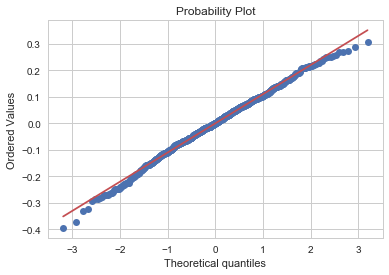

In [89]:
# QQplot 확인
sp.stats.probplot(result_sel3.resid, plot=plt)
plt.show()

In [90]:
# 1%로 채택....
test = sms.omni_normtest(result_sel3.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  7.613
P-value     :  0.022


# test data

In [91]:
df_test = pd.read_csv('./data/test.csv')
in_dex = df_test['Id']
df_test = df_test.set_index("Id")


grade_col=['ExterQual','ExterCond','BsmtQual','BsmtCond', 'HeatingQC', 'KitchenQual', "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]
df_test[grade_col] = df_test[grade_col].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po','NA'], [5,4,3,2,1,0]).fillna(0)
df_test['BsmtExposure'] = df_test['BsmtExposure'].replace(['Gd', 'Av', 'Mn', 'No', 'Na'],[4,3,2,1,0]).fillna(0)
df_test[['BsmtFinType1', 'BsmtFinType2']] = df_test[['BsmtFinType1', 'BsmtFinType2']].replace(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ','Unf', 'NA'],[6,5,4,3,2,1,0]).fillna(0)
df_test['Functional'] = df_test['Functional'].replace(['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],[7,6,5,4,3,2,1,0]).fillna(0)
df_test["GarageFinish"] = df_test["GarageFinish"].replace(['Fin', 'RFn', 'Unf', 'NA'],[3,2,1,0]).fillna(0)
df_test["Fence"] = df_test["Fence"].replace(['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA' ],[4,3,2,1,0]).fillna(0)
df_test['BsmtUnfSF'] = np.log(df_test['BsmtUnfSF'])
df_test['LotArea'] = np.log(df_test['LotArea'])

/Users/Dong-hyun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


In [92]:
df_test_SalePrice = np.exp(result_sel3.predict(df_test)).head()

for i in df_test_SalePrice.index:
    print(i,df_test_SalePrice.loc[i])

10 125521.337522
13 115890.448638
17 150059.741497
18 106451.968254
20 128545.153048


In [93]:
with open('House_Price_answer.csv', 'w') as csvfile:
    fieldnames = ['Id', 'SalePrice']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in df_test_SalePrice.index:
        writer.writerow({'Id' : i, 'SalePrice' : df_test_SalePrice.loc[i]})